## Data Acquisition

In [1]:
import sys
import warnings
import os

warnings.filterwarnings('ignore')
sys.path.append('../')

In [2]:
from Modules.scraping import *
from Modules.support_functions import *
from Modules.Growth_curve_fitting import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wwo_hist import retrieve_hist_data

In [3]:
data = cut_down(scrap_covid_data())

# START scraping
### Requesting url nr 1
### Requesting url nr 2
# END scraping


In [13]:
# Rescaling core features
def scale_features_by_state(df, STATES):
    for state in STATES:
        df.loc[df['Province/State'] == state, "Deaths"] = df[df['Province/State'] == state].Deaths.transform(lambda x: x*(1/x.max())).fillna(0)
        df.loc[df['Province/State'] == state, "Infected"] = df[df['Province/State'] == state].Infected.transform(lambda x: x*(1/x.max())).fillna(0)
#         df.loc[df['Province/State'] == state, "Recovered"] = df[df['Province/State'] == state].Recovered.transform(lambda x: x*(1/x.max())).fillna(0)
    return df

# Annotating time point zero: first infection
def find_timepoint_zero(df):
    df["Timepoint"] = -1

    point_zero = df.loc[df['Infected']>0, "Date"][0]
    df.loc[df['Date'] == point_zero, "Timepoint"] = 0

    previous = -1
    for i, row in df.iterrows():
        if i == point_zero or previous != -1:
            previous = previous + 1
            df.at[i,'Timepoint'] = previous
            
    return df

# Generating time lag feature
def create_lag_feat(df, lags = 1):
    if lags >= 1: df["Infected_T-1"] = df.Infected.shift(1).fillna(0)
    if lags >= 2: df["Infected_T-2"] = df.Infected.shift(2).fillna(0)
    if lags == 3: df["Infected_T-3"] = df.Infected.shift(3).fillna(0)
    if lags >= 1: df["Deaths_T-1"] = df.Deaths.shift(1).fillna(0)
    if lags >= 2: df["Deaths_T-2"] = df.Deaths.shift(2).fillna(0)
    if lags == 3: df["Deaths_T-3"] = df.Deaths.shift(3).fillna(0)
    if lags >= 1: df["Deaths_T-1"] = df.Deaths.shift(1).fillna(0)
    if lags >= 1: df["Recovered_T-1"] = df.Recovered.shift(1).fillna(0)
    if lags >= 2: df["Recovered_T-2"] = df.Recovered.shift(2).fillna(0)
    if lags == 3: df["Recovered_T-3"] = df.Recovered.shift(3).fillna(0)

    return df

# Generating rolling window feature
def create_rolwin_feat(df):
    df["Infected_rolwin_T-1_T-2"] = df.Infected.shift(1).rolling(window=2).mean().fillna(0)
    df["Deaths_rolwin_T-1_T-2"] = df.Deaths.shift(1).rolling(window=2).mean().fillna(0)
    df["Recovered_rolwin_T-1_T-2"] = df.Recovered.shift(1).rolling(window=2).mean().fillna(0)
    return df

# Generating expanding window feature
def create_expwin_feat(df):
    df["Infected_win_mean"] = df.Infected.expanding().mean()
    df["Deaths_win_mean"] = df.Deaths.expanding().mean()
    df["Recovered_win_mean"] = df.Recovered.expanding().mean()
    
    return df

# Add weather features given weather df
def add_weather_feature(df, weather_df):
    df["tempC"] = weather_df["tempC"].values
    df["FeelsLikeC"] = weather_df["FeelsLikeC"].values
    df["sunHour"] = weather_df["sunHour"].values
    df["totalSnow_cm"] = weather_df["totalSnow_cm"].values
    return df

## China

In [5]:
# Get chinese data
CH = country_filter(data, Country='China')

#Calculate the distance to Hubei 
CH['Distance'] = np.square(np.power(CH['Long']-CH.loc[CH['Province/State']=='Hubei','Long'],2)+np.power(CH['Lat']-CH.loc[CH['Province/State']=='Hubei','Lat'],2))

# Get stated ordered by distance
STATES_CH = CH.sort_values('Distance')['Province/State'].drop_duplicates()

CH = scale_features_by_state(CH, STATES_CH)

In [6]:
close_states_ch = CH[CH['Province/State'].isin(STATES_CH[:int(len(STATES_CH)/4)])]
mid_close_ch =  CH[CH['Province/State'].isin(STATES_CH[int(len(STATES_CH)/4):int(len(STATES_CH)/4)*2])]
mid_far_ch =  CH[CH['Province/State'].isin(STATES_CH[2*int(len(STATES_CH)/4):int(len(STATES_CH)/4)*3])]
far_states_ch =  CH[CH['Province/State'].isin(STATES_CH[3*int(len(STATES_CH)/4):])]

Text(0.5, 1.0, 'close_states_ch')

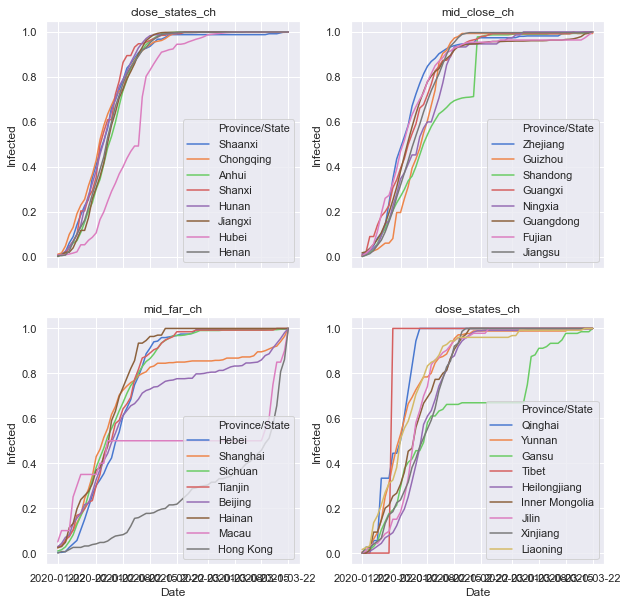

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid", palette="muted", color_codes=True)

f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
sns.lineplot(x="Date", y="Infected", hue="Province/State", data=close_states_ch, ax=axes[0, 0]).set_title("close_states_ch")
sns.lineplot(x="Date", y="Infected", hue="Province/State", data=mid_close_ch, ax=axes[0, 1]).set_title("mid_close_ch")
sns.lineplot(x="Date", y="Infected", hue="Province/State", data=mid_far_ch, ax=axes[1, 0]).set_title("mid_far_ch")
sns.lineplot(x="Date", y="Infected", hue="Province/State", data=far_states_ch, ax=axes[1, 1]).set_title("close_states_ch")

### South Korea

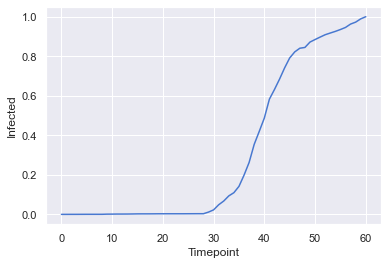

In [8]:
# South Korea
SK = country_filter(data, Country='Korea, South')
SK = find_timepoint_zero(SK)
SK = scale_features_by_state(SK, SK['Province/State'].drop_duplicates())
SK = create_lag_feat(SK)
SK = create_rolwin_feat(SK)
SK = create_expwin_feat(SK)
SK = SK[SK.Timepoint != -1]
ax = sns.lineplot(x="Timepoint", y="Infected", data=SK)

# Time series forecasting with ARIMA

In [9]:
import itertools
import statsmodels.api as sm

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [10]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [11]:
y = SK.Infected

In [15]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:91.69430783139224
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:57.976683164569955
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:35.043341472664665
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:36.55765457129262
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:25.355167071577302
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:27.662488156282485
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:29.500849228152287
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:31.78859676861838
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:17.343998330788537
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-0.7868908193309743
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-24.645834639756945
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-8.441374610737402
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-35.91491906328899
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-30.529027131060083
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-15.659942442381123
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-11.589286244269584
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-246.25002221215453
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-186.378

The above output suggests that SARIMAX(0, 0, 1)x(0, 0, 1, 12) yields the best AIC value of -0.78. Therefore we should consider this to be optimal option.


In [16]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 0, 1),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9800      0.304      3.221      0.001       0.384       1.576
ma.S.L12       0.9453      1.747      0.541      0.589      -2.480       4.370
sigma2         0.0301      0.051      0.595      0.552      -0.069       0.129


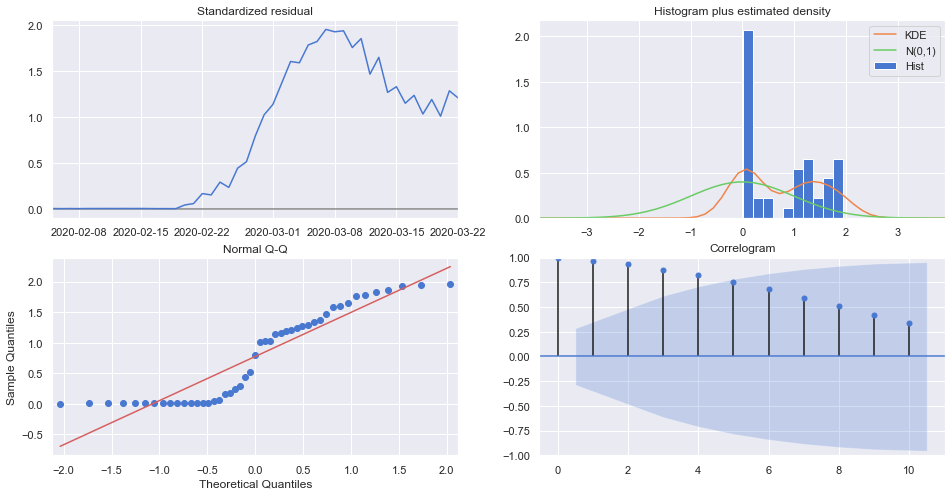

In [17]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Validating Forecast

In [23]:
pd.plotting.register_matplotlib_converters()

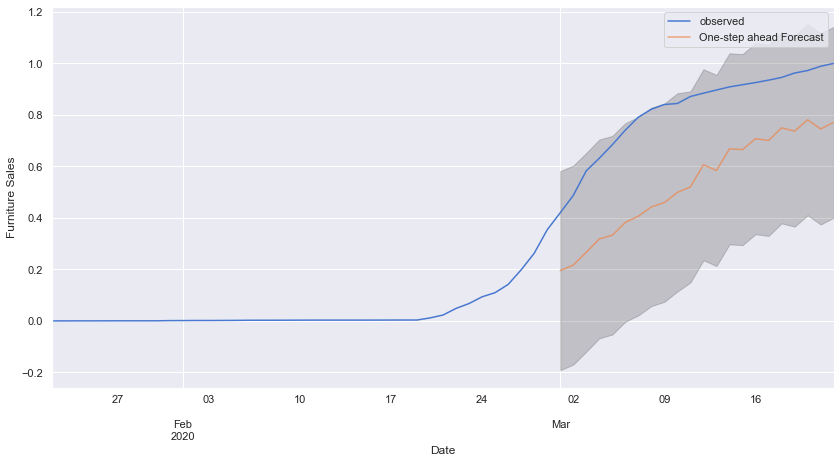

In [19]:
pred = results.get_prediction(start=pd.to_datetime('2020-03-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [20]:
y_forecasted = pred.predicted_mean
y_truth = y['2020-03-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 0.09
The Root Mean Squared Error of our forecasts is 0.29


## Covid 19 Modeling with Prophet

In [21]:
from fbprophet import Prophet

SK = SK.rename(columns={'Date': 'ds', 'Infected': 'y'})
SK_model = Prophet(interval_width=0.95)
SK_model.fit(SK)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


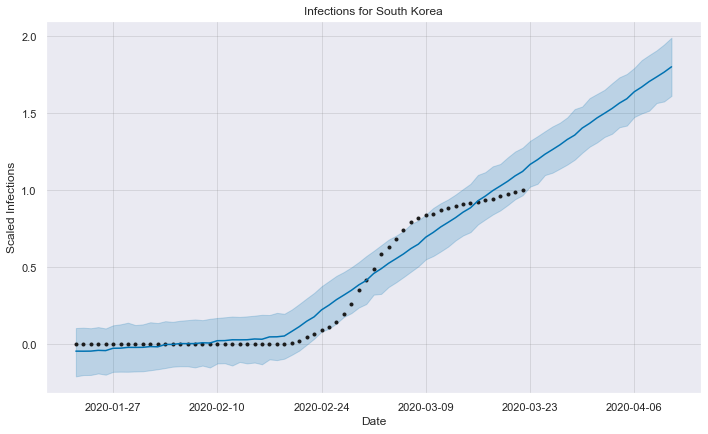

In [24]:
# Make a future dataframe for 20 Days
SK_forecast = SK_model.make_future_dataframe(periods=20, freq='D')
SK_forecast = SK_model.predict(SK_forecast)

pd.plotting.register_matplotlib_converters()
SK_model.plot(SK_forecast, xlabel = 'Date', ylabel = 'Scaled Infections')
plt.title('Infections for South Korea');

## Weather Data

In [3]:
frequency = 24
start_date = '22-JAN-2020'
end_date = '28-MAR-2020'
api_key = 'f2c76ab75910443592c104308202903'

In [4]:
# Germany
location_list = ['Germany']
os.chdir("../Data/weather/germany")

hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True,
                                store_df = True)



Retrieving weather data for Germany


Currently retrieving data for Germany: from 2020-01-22 to 2020-01-31
Time elapsed (hh:mm:ss.ms) 0:00:00.337576
Currently retrieving data for Germany: from 2020-02-01 to 2020-02-29
Time elapsed (hh:mm:ss.ms) 0:00:01.002762
Currently retrieving data for Germany: from 2020-03-01 to 2020-03-28
Time elapsed (hh:mm:ss.ms) 0:00:01.614579


export Germany completed!




In [32]:
# China
location_list = STATES_CH
# os.chdir("../Data/weather/china")

hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True,
                                store_df = True)



Retrieving weather data for Liaoning


Currently retrieving data for Liaoning: from 2020-01-22 to 2020-01-31
Time elapsed (hh:mm:ss.ms) 0:00:00.493992
Currently retrieving data for Liaoning: from 2020-02-01 to 2020-02-29
Time elapsed (hh:mm:ss.ms) 0:00:01.717752
Currently retrieving data for Liaoning: from 2020-03-01 to 2020-03-28
Time elapsed (hh:mm:ss.ms) 0:00:03.500393


export Liaoning completed!




Retrieving weather data for Qinghai


Currently retrieving data for Qinghai: from 2020-01-22 to 2020-01-31
Time elapsed (hh:mm:ss.ms) 0:00:00.679356
Currently retrieving data for Qinghai: from 2020-02-01 to 2020-02-29
Time elapsed (hh:mm:ss.ms) 0:00:02.056784
Currently retrieving data for Qinghai: from 2020-03-01 to 2020-03-28
Time elapsed (hh:mm:ss.ms) 0:00:03.232950


export Qinghai completed!




Retrieving weather data for Jilin


Currently retrieving data for Jilin: from 2020-01-22 to 2020-01-31
Time elapsed (hh:mm:ss.ms) 0:00:00.757161
Currently retrieving data for Jilin: from 

In [8]:
GER_weather = pd.read_csv("../Data/weather/germany/Germany.csv")
GER = country_filter(data, Country='Germany')

In [14]:
GER = add_weather_feature(GER, GER_weather)

In [34]:
print(len(GER_weather["sunHour"]))
print(len(GER["sunHour"]))


GER["sunHour"] = GER_weather["sunHour"].values

67
67


In [35]:
GER.head(5)

,Province/State,Country/Region,Lat,Long,Date,Infected,Deaths,tempC,FeelsLikeC,sunHour,totalSnow_cm
Date,,,,,,,,,,,
2020-01-22,Germany,Germany,51.0,9.0,2020-01-22,0.0,0.0,NaN,NaN,2.1,NaN
2020-01-23,Germany,Germany,51.0,9.0,2020-01-23,0.0,0.0,NaN,NaN,3.9,NaN
2020-01-24,Germany,Germany,51.0,9.0,2020-01-24,0.0,0.0,NaN,NaN,5.8,NaN
2020-01-25,Germany,Germany,51.0,9.0,2020-01-25,0.0,0.0,NaN,NaN,5.1,NaN
2020-01-26,Germany,Germany,51.0,9.0,2020-01-26,0.0,0.0,NaN,NaN,8.7,NaN


In [19]:
GER_weather.head(5)

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2020-01-22,6,2,0.0,2.1,1,1,11,07:16 AM,03:04 PM,...,1,24,74,87,0.4,1032,6,10,290,16
1,2020-01-23,4,1,0.0,3.9,1,1,3,08:14 AM,03:57 PM,...,0,12,53,93,0.0,1032,4,6,247,8
2,2020-01-24,5,-2,0.0,5.8,1,1,0,09:02 AM,04:59 PM,...,0,12,30,80,0.0,1023,5,10,234,8
3,2020-01-25,3,0,0.0,5.1,1,1,0,09:39 AM,06:06 PM,...,-1,13,69,75,0.0,1021,3,10,252,9
4,2020-01-26,4,0,0.0,8.7,1,1,4,10:07 AM,07:15 PM,...,0,11,31,71,0.0,1018,4,10,196,7
